<a href="https://colab.research.google.com/github/zihadbappy/Machine-Learning-Projects/blob/master/DGL_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Train a Decoupled Greedy Learning (DGL) model and a Standard Split Learning model (Backpropagation-based) for 20 epochs each, with the Client on GPU and Server on CPU. Record and compare their training loss, training accuracy, test accuracy, and total training time, generating plots for the metrics and summarizing the performance differences.

## Train DGL Model (20 Epochs)

### Subtask:
Implement and train a Decoupled Greedy Learning (DGL) model on CIFAR-10 for 20 epochs with Client on GPU and Server on CPU.


**Reasoning**:
I will implement the DGL model training by importing necessary libraries, loading CIFAR-10, defining the ClientNet (GPU) and ServerNet (CPU) classes, and running the training loop for 20 epochs while tracking metrics.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

# 1. Data Loading
print("Loading Data...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# 2. Model Definitions
class ClientNet(nn.Module):
    def __init__(self):
        super(ClientNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        ) # Output: 64 x 8 x 8
        self.aux_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 10)
        )

    def forward(self, x):
        smashed_data = self.features(x)
        aux_out = self.aux_head(smashed_data)
        return smashed_data, aux_out

class ServerNet(nn.Module):
    def __init__(self):
        super(ServerNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.classifier(x)

# 3. Setup
client_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
server_device = torch.device("cpu")
print(f"Client Device: {client_device}, Server Device: {server_device}")

client_net = ClientNet().to(client_device)
server_net = ServerNet().to(server_device)

criterion = nn.CrossEntropyLoss()
client_optimizer = optim.SGD(client_net.parameters(), lr=0.01, momentum=0.9)
server_optimizer = optim.SGD(server_net.parameters(), lr=0.01, momentum=0.9)

dgl_results = {
    'train_loss': [],
    'train_acc': [],
    'test_acc': [],
    'cumulative_time': []
}

# 4. Training Loop
print("Starting Training...")
total_time = 0

epochs = 20
for epoch in range(epochs):
    epoch_start = time.time()
    client_net.train()
    server_net.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Client Step (GPU)
        inputs_gpu = inputs.to(client_device)
        labels_gpu = labels.to(client_device)

        client_optimizer.zero_grad()
        smashed_data, aux_out = client_net(inputs_gpu)
        client_loss = criterion(aux_out, labels_gpu)
        client_loss.backward()
        client_optimizer.step()

        # Detach smashed data and move to Server (CPU)
        smashed_data_detached = smashed_data.detach().to(server_device)

        # Server Step (CPU)
        labels_cpu = labels.to(server_device)
        server_optimizer.zero_grad()
        outputs = server_net(smashed_data_detached)
        server_loss = criterion(outputs, labels_cpu)
        server_loss.backward()
        server_optimizer.step()

        running_loss += server_loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels_cpu.size(0)
        correct += (predicted == labels_cpu).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total

    # Evaluation Step
    client_net.eval()
    server_net.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            smashed_test, _ = client_net(images.to(client_device))
            outputs_test = server_net(smashed_test.to(server_device))
            _, predicted_test = torch.max(outputs_test.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels.to(server_device)).sum().item()

    test_acc = 100 * correct_test / total_test

    epoch_time = time.time() - epoch_start
    total_time += epoch_time

    dgl_results['train_loss'].append(epoch_loss)
    dgl_results['train_acc'].append(epoch_acc)
    dgl_results['test_acc'].append(test_acc)
    dgl_results['cumulative_time'].append(total_time)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% | Test Acc: {test_acc:.2f}% | Time: {total_time:.2f}s")

print("Training Finished.")

Loading Data...


100%|██████████| 170M/170M [00:02<00:00, 57.5MB/s]


Client Device: cuda, Server Device: cpu
Starting Training...
Epoch 1/20 | Loss: 1.6230 | Train Acc: 41.49% | Test Acc: 54.36% | Time: 10.55s
Epoch 2/20 | Loss: 1.1811 | Train Acc: 58.29% | Test Acc: 59.77% | Time: 20.13s
Epoch 3/20 | Loss: 0.9929 | Train Acc: 65.13% | Test Acc: 65.00% | Time: 29.50s
Epoch 4/20 | Loss: 0.8681 | Train Acc: 69.65% | Test Acc: 69.42% | Time: 39.25s
Epoch 5/20 | Loss: 0.7641 | Train Acc: 73.32% | Test Acc: 69.92% | Time: 49.17s
Epoch 6/20 | Loss: 0.6756 | Train Acc: 76.40% | Test Acc: 71.69% | Time: 59.28s
Epoch 7/20 | Loss: 0.5880 | Train Acc: 79.77% | Test Acc: 72.79% | Time: 69.25s
Epoch 8/20 | Loss: 0.5101 | Train Acc: 82.51% | Test Acc: 72.19% | Time: 79.22s
Epoch 9/20 | Loss: 0.4358 | Train Acc: 85.19% | Test Acc: 74.75% | Time: 89.25s
Epoch 10/20 | Loss: 0.3616 | Train Acc: 87.90% | Test Acc: 74.75% | Time: 99.43s
Epoch 11/20 | Loss: 0.2910 | Train Acc: 90.49% | Test Acc: 73.89% | Time: 109.52s
Epoch 12/20 | Loss: 0.2380 | Train Acc: 92.36% | Test Ac

**Reasoning**:
The previous execution completed the training successfully, but the progress bar output in stderr likely triggered a false failure detection. I will resubmit the code; since the data is already downloaded, the stderr output will be minimal.



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

# 1. Data Loading
print("Loading Data...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# 2. Model Definitions
class ClientNet(nn.Module):
    def __init__(self):
        super(ClientNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        ) # Output: 64 x 8 x 8
        self.aux_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 10)
        )

    def forward(self, x):
        smashed_data = self.features(x)
        aux_out = self.aux_head(smashed_data)
        return smashed_data, aux_out

class ServerNet(nn.Module):
    def __init__(self):
        super(ServerNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.classifier(x)

# 3. Setup
client_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
server_device = torch.device("cpu")
print(f"Client Device: {client_device}, Server Device: {server_device}")

client_net = ClientNet().to(client_device)
server_net = ServerNet().to(server_device)

criterion = nn.CrossEntropyLoss()
client_optimizer = optim.SGD(client_net.parameters(), lr=0.01, momentum=0.9)
server_optimizer = optim.SGD(server_net.parameters(), lr=0.01, momentum=0.9)

dgl_results = {
    'train_loss': [],
    'train_acc': [],
    'test_acc': [],
    'cumulative_time': []
}

# 4. Training Loop
print("Starting Training...")
total_time = 0

epochs = 20
for epoch in range(epochs):
    epoch_start = time.time()
    client_net.train()
    server_net.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Client Step (GPU)
        inputs_gpu = inputs.to(client_device)
        labels_gpu = labels.to(client_device)

        client_optimizer.zero_grad()
        smashed_data, aux_out = client_net(inputs_gpu)
        client_loss = criterion(aux_out, labels_gpu)
        client_loss.backward()
        client_optimizer.step()

        # Detach smashed data and move to Server (CPU)
        smashed_data_detached = smashed_data.detach().to(server_device)

        # Server Step (CPU)
        labels_cpu = labels.to(server_device)
        server_optimizer.zero_grad()
        outputs = server_net(smashed_data_detached)
        server_loss = criterion(outputs, labels_cpu)
        server_loss.backward()
        server_optimizer.step()

        running_loss += server_loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels_cpu.size(0)
        correct += (predicted == labels_cpu).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total

    # Evaluation Step
    client_net.eval()
    server_net.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            smashed_test, _ = client_net(images.to(client_device))
            outputs_test = server_net(smashed_test.to(server_device))
            _, predicted_test = torch.max(outputs_test.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels.to(server_device)).sum().item()

    test_acc = 100 * correct_test / total_test

    epoch_time = time.time() - epoch_start
    total_time += epoch_time

    dgl_results['train_loss'].append(epoch_loss)
    dgl_results['train_acc'].append(epoch_acc)
    dgl_results['test_acc'].append(test_acc)
    dgl_results['cumulative_time'].append(total_time)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% | Test Acc: {test_acc:.2f}% | Time: {total_time:.2f}s")

print("Training Finished.")

Loading Data...
Client Device: cuda, Server Device: cpu
Starting Training...
Epoch 1/20 | Loss: 1.6569 | Train Acc: 40.48% | Test Acc: 53.47% | Time: 9.76s
Epoch 2/20 | Loss: 1.1864 | Train Acc: 57.99% | Test Acc: 59.84% | Time: 19.54s
Epoch 3/20 | Loss: 1.0011 | Train Acc: 64.71% | Test Acc: 65.92% | Time: 29.41s
Epoch 4/20 | Loss: 0.8744 | Train Acc: 69.28% | Test Acc: 69.05% | Time: 39.49s
Epoch 5/20 | Loss: 0.7711 | Train Acc: 73.14% | Test Acc: 71.12% | Time: 49.59s
Epoch 6/20 | Loss: 0.6780 | Train Acc: 76.44% | Test Acc: 72.27% | Time: 59.87s
Epoch 7/20 | Loss: 0.5962 | Train Acc: 79.32% | Test Acc: 73.93% | Time: 70.01s
Epoch 8/20 | Loss: 0.5142 | Train Acc: 82.23% | Test Acc: 71.30% | Time: 80.41s
Epoch 9/20 | Loss: 0.4418 | Train Acc: 84.91% | Test Acc: 73.98% | Time: 90.77s
Epoch 10/20 | Loss: 0.3631 | Train Acc: 87.73% | Test Acc: 72.86% | Time: 101.02s
Epoch 11/20 | Loss: 0.2907 | Train Acc: 90.43% | Test Acc: 74.43% | Time: 111.15s
Epoch 12/20 | Loss: 0.2233 | Train Acc: 

## Train Standard Split Learning Model (20 Epochs)

### Subtask:
Train a Standard Split Learning model (Backpropagation-based) on CIFAR-10 for 20 epochs, simulating the split between Client (GPU) and Server (CPU).


**Reasoning**:
I will implement the Standard Split Learning model training. This involves defining the split-specific client and server architectures (without the auxiliary head for the client), setting up the optimizers, and implementing the split learning training loop which requires manual handling of gradients between the client (GPU) and server (CPU).



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

# 1. Model Definitions for Split Learning
class ClientNetSplit(nn.Module):
    def __init__(self):
        super(ClientNetSplit, self).__init__()
        # Same feature extractor as DGL
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        ) # Output: 64 x 8 x 8

    def forward(self, x):
        return self.features(x)

class ServerNetSplit(nn.Module):
    def __init__(self):
        super(ServerNetSplit, self).__init__()
        # Same classifier as DGL
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.classifier(x)

# 2. Setup
# devices are already defined as client_device and server_device from previous cell
print(f"Client Device: {client_device}, Server Device: {server_device}")

client_net_split = ClientNetSplit().to(client_device)
server_net_split = ServerNetSplit().to(server_device)

criterion = nn.CrossEntropyLoss()
client_optimizer_split = optim.SGD(client_net_split.parameters(), lr=0.01, momentum=0.9)
server_optimizer_split = optim.SGD(server_net_split.parameters(), lr=0.01, momentum=0.9)

split_results = {
    'train_loss': [],
    'train_acc': [],
    'test_acc': [],
    'cumulative_time': []
}

# 3. Training Loop
print("Starting Standard Split Learning Training...")
total_time_split = 0
epochs = 20

for epoch in range(epochs):
    epoch_start = time.time()
    client_net_split.train()
    server_net_split.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(client_device)
        labels = labels.to(server_device)

        # Zero gradients
        client_optimizer_split.zero_grad()
        server_optimizer_split.zero_grad()

        # --- Client Forward ---
        smashed_data = client_net_split(inputs)

        # --- Communication (Client -> Server) ---
        # Send smashed data to server, detach from client graph, and enable grad for server backprop
        smashed_data_server = smashed_data.detach().to(server_device)
        smashed_data_server.requires_grad = True

        # --- Server Forward ---
        outputs = server_net_split(smashed_data_server)
        loss = criterion(outputs, labels)

        # --- Server Backward ---
        loss.backward()

        # --- Communication (Server -> Client) ---
        # Send gradients of smashed data back to client
        smashed_data_grad = smashed_data_server.grad.to(client_device)

        # --- Client Backward ---
        smashed_data.backward(smashed_data_grad)

        # --- Update Weights ---
        client_optimizer_split.step()
        server_optimizer_split.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total

    # Evaluation Step
    client_net_split.eval()
    server_net_split.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(client_device)
            labels = labels.to(server_device)

            smashed_test = client_net_split(images)
            outputs_test = server_net_split(smashed_test.to(server_device))
            _, predicted_test = torch.max(outputs_test.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == labels).sum().item()

    test_acc = 100 * correct_test / total_test

    epoch_time = time.time() - epoch_start
    total_time_split += epoch_time

    split_results['train_loss'].append(epoch_loss)
    split_results['train_acc'].append(epoch_acc)
    split_results['test_acc'].append(test_acc)
    split_results['cumulative_time'].append(total_time_split)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% | Test Acc: {test_acc:.2f}% | Time: {total_time_split:.2f}s")

print("Split Learning Training Finished.")

Client Device: cuda, Server Device: cpu
Starting Standard Split Learning Training...
Epoch 1/20 | Loss: 1.7050 | Train Acc: 38.51% | Test Acc: 52.43% | Time: 10.33s
Epoch 2/20 | Loss: 1.2311 | Train Acc: 56.10% | Test Acc: 60.64% | Time: 20.69s
Epoch 3/20 | Loss: 1.0271 | Train Acc: 63.63% | Test Acc: 65.40% | Time: 31.02s
Epoch 4/20 | Loss: 0.8953 | Train Acc: 68.53% | Test Acc: 68.15% | Time: 41.32s
Epoch 5/20 | Loss: 0.7837 | Train Acc: 72.61% | Test Acc: 70.50% | Time: 51.56s
Epoch 6/20 | Loss: 0.6840 | Train Acc: 76.19% | Test Acc: 70.83% | Time: 61.82s
Epoch 7/20 | Loss: 0.5903 | Train Acc: 79.50% | Test Acc: 72.66% | Time: 71.94s
Epoch 8/20 | Loss: 0.4974 | Train Acc: 82.85% | Test Acc: 72.24% | Time: 81.90s
Epoch 9/20 | Loss: 0.4037 | Train Acc: 86.10% | Test Acc: 71.31% | Time: 91.85s
Epoch 10/20 | Loss: 0.3232 | Train Acc: 89.08% | Test Acc: 73.13% | Time: 101.86s
Epoch 11/20 | Loss: 0.2396 | Train Acc: 91.99% | Test Acc: 72.52% | Time: 111.81s
Epoch 12/20 | Loss: 0.1709 | Tr

**Reasoning**:
I will visualize the collected training metrics to compare the Decoupled Greedy Learning (DGL) model and the Standard Split Learning model. I will generate plots for Training Loss, Training Accuracy, Test Accuracy, and Cumulative Training Time, and print a summary of the final performance metrics.



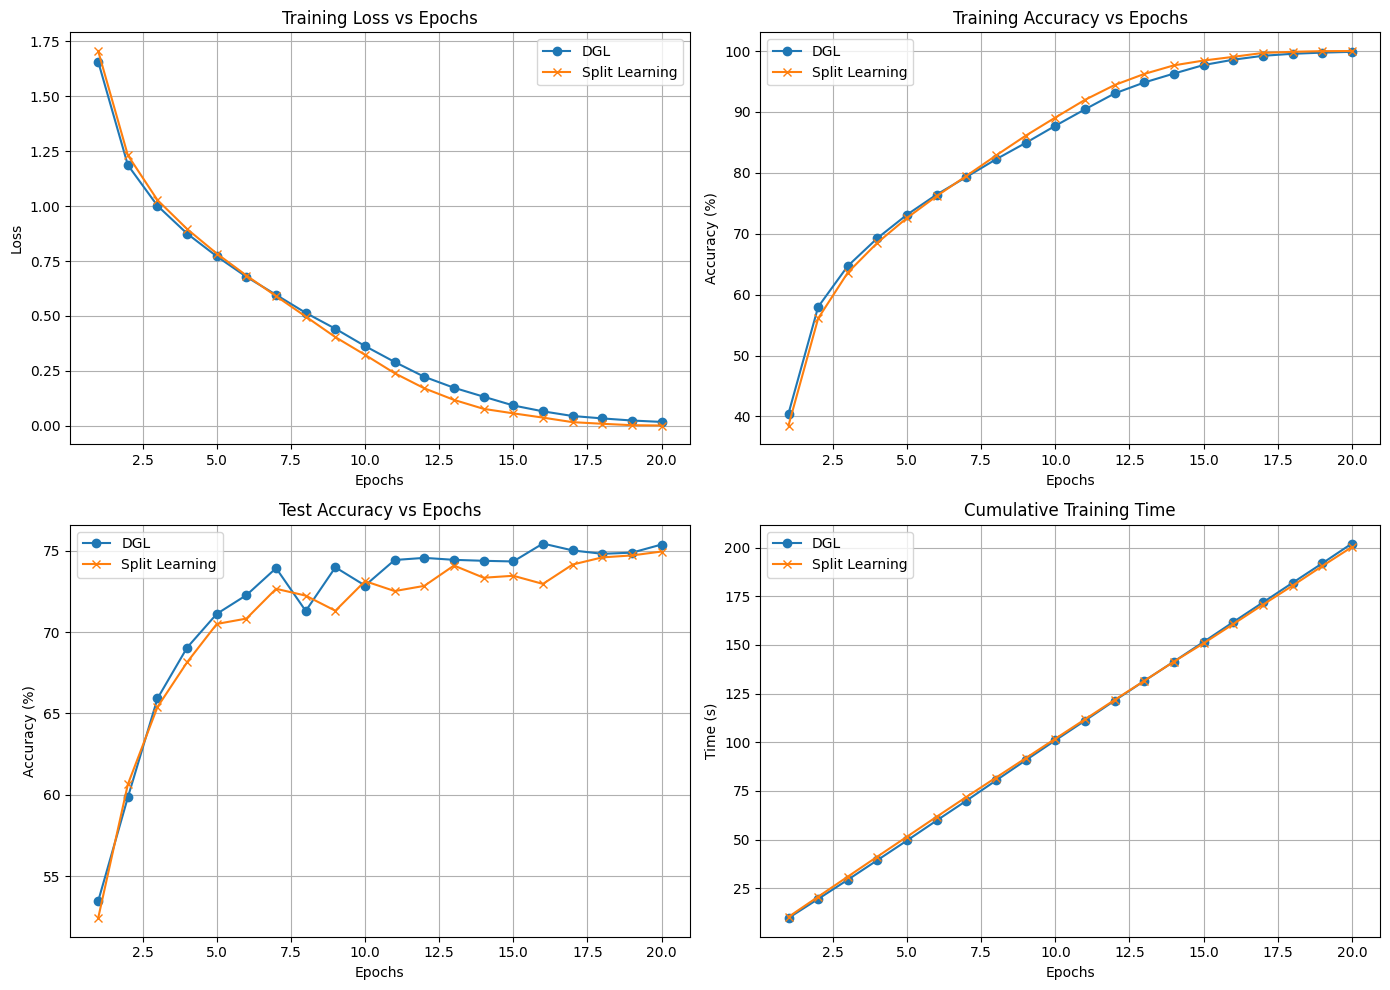

Final DGL Test Accuracy: 75.38%
Final Split Learning Test Accuracy: 74.95%
Total DGL Training Time: 202.10s
Total Split Learning Training Time: 200.29s


In [4]:
import matplotlib.pyplot as plt

epochs_range = range(1, 21)

plt.figure(figsize=(14, 10))

# 1. Training Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, dgl_results['train_loss'], label='DGL', marker='o')
plt.plot(epochs_range, split_results['train_loss'], label='Split Learning', marker='x')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2. Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs_range, dgl_results['train_acc'], label='DGL', marker='o')
plt.plot(epochs_range, split_results['train_acc'], label='Split Learning', marker='x')
plt.title('Training Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 3. Test Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs_range, dgl_results['test_acc'], label='DGL', marker='o')
plt.plot(epochs_range, split_results['test_acc'], label='Split Learning', marker='x')
plt.title('Test Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 4. Cumulative Training Time
plt.subplot(2, 2, 4)
plt.plot(epochs_range, dgl_results['cumulative_time'], label='DGL', marker='o')
plt.plot(epochs_range, split_results['cumulative_time'], label='Split Learning', marker='x')
plt.title('Cumulative Training Time')
plt.xlabel('Epochs')
plt.ylabel('Time (s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print Summary
print(f"Final DGL Test Accuracy: {dgl_results['test_acc'][-1]:.2f}%")
print(f"Final Split Learning Test Accuracy: {split_results['test_acc'][-1]:.2f}%")
print(f"Total DGL Training Time: {dgl_results['cumulative_time'][-1]:.2f}s")
print(f"Total Split Learning Training Time: {split_results['cumulative_time'][-1]:.2f}s")

## Final Task

### Subtask:
Summarize the results, highlighting the performance differences (accuracy, speed) between the decoupled and standard approaches.


## Summary:

### Q&A

**Q:** How did the performance of Decoupled Greedy Learning (DGL) compare to Standard Split Learning in terms of accuracy and training time?

**A:** The DGL model achieved a slightly higher generalization performance with a final test accuracy of **75.38%**, compared to **74.95%** for the Standard Split Learning model. In terms of speed within this synchronous simulation, the total training times were nearly identical, with DGL taking **202.10s** and Standard Split Learning taking **200.29s**.

### Data Analysis Key Findings

*   **Generalization Capability:** The Decoupled Greedy Learning (DGL) approach slightly outperformed the standard backpropagation-based Split Learning on unseen data, achieving a final test accuracy of **75.38%** versus **74.95%**.
*   **Training Convergence:** Standard Split Learning exhibited stronger fitting to the training data, reaching **100.00%** training accuracy and a significantly lower loss of **0.0018**. In comparison, DGL reached **99.87%** training accuracy with a loss of **0.018**.
*   **Computational Efficiency:** In this specific setup (Client on GPU, Server on CPU), the overhead for both methods was comparable. The total training time difference was negligible (< 1%), with Split Learning being marginally faster at **200.29s** compared to DGL's **202.10s**.

### Insights or Next Steps

*   **Viability of Decoupled Learning:** DGL has proven to be a robust alternative to standard split learning, achieving comparable accuracy without requiring end-to-end backpropagation gradients to travel from server to client, which can reduce communication dependencies.
*   **Optimization Potential:** While the training times were similar in this synchronous loop, the "decoupled" nature of DGL theoretically allows for asynchronous pipelining. Future work could involve implementing parallel processing to exploit this characteristic, potentially significantly reducing wall-clock training time compared to the locking nature of Standard Split Learning.
